In [1]:
import maze_library
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random

In [2]:
help(maze_library.init_environment)

Help on built-in function init_environment in module maze_library.maze_library:

init_environment(width, height, gen_algorithm='kruzkals', allowed_revisits=50, use_sparse_rewards=False, use_weighted_graph=True, rng_seed=None)



In [3]:
env = maze_library.init_environment(16,16,allowed_revisits=100)
maze_library.make_maze_imperfect(env)

In [4]:


class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.out = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        return self.out(x)
    
    
input_size = 19
output_size = 4
model = DQN(input_size, output_size)
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)
loss_fn = nn.HuberLoss()
replay_buffer = deque(maxlen=10000)


In [5]:
def epsilon_greedy_policy(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, output_size - 1)
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = model(state_tensor)
        return int(torch.argmax(q_values).item())


In [6]:
from collections import deque

replay_buffer = deque(maxlen=8000)

In [7]:
# def sample_experiences(batch_size):
#     sorted_experiences = sorted(replay_buffer, key=lambda exp: abs(exp[2]), reverse=True)
#     half_batch = batch_size // 2

#     # Ensure there are enough samples to choose from
#     num_experiences = len(sorted_experiences)
#     if num_experiences < batch_size:
#         batch = sorted_experiences
#     else:
#         high_priority_samples = sorted_experiences[:half_batch]
#         random_samples = [sorted_experiences[i] for i in np.random.choice(num_experiences, half_batch, replace=False)]
#         batch = high_priority_samples + random_samples
    
#     return [
#         np.array([experience[field_index] for experience in batch], dtype=np.float32)
#         for field_index in range(6)
#     ]

def sample_experiences(batch_size):
    indices = np.random.choice(len(replay_buffer), min(batch_size, len(replay_buffer)), replace=False)
    batch = [replay_buffer[i] for i in indices]
    return zip(*batch)



In [8]:
reward_log = []
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    action_obj = maze_library.create_action(action, 0)
    next_state, reward, done, truncated = env.take_action(action_obj)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    reward_log.append(reward)
    return next_state, reward, done, truncated

In [9]:
np.random.seed(42)
rewards = [] 
highest_reward = -1000000

In [10]:
discount_factor = 0.96
q_value_log = []


def training_step(batch_size, discount_factor=0.94):
    states, actions, rewards, next_states, dones, truncateds = sample_experiences(batch_size)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)
    truncateds = torch.tensor(truncateds, dtype=torch.float32)

    with torch.no_grad():
        next_q = model(next_states)
        max_next_q = next_q.max(dim=1)[0]
        terminal = torch.logical_or(dones.bool(), truncateds.bool()).float()

        target_q = rewards + (1 - dones) * discount_factor * max_next_q

    q_values = model(states)
    selected_q = q_values.gather(1, actions.unsqueeze(1)).squeeze()
    loss = loss_fn(selected_q, target_q)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    q_value_log.extend(selected_q.detach().numpy())

In [11]:
# Visualization function
def plot_q_values():
    plt.figure(figsize=(10, 5))
    plt.plot(q_value_log)
    plt.title("Q-Values Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("Q-Value")
    plt.grid(True)
    plt.show()


In [12]:
steps = 10000
batch_size = 128

# In the plotting function:
for episode in range(steps):
    obs = env.reset()
    cumilative_reward = 0
    for step in range(steps):
        epsilon = max(1 - episode / (steps * 0.9), 0.01)
        obs, reward, done, truncated = play_one_step(env, obs, epsilon)
        cumilative_reward += reward
        if done or truncated:
            break

    # Extra debug information
    if episode% 100 == 0 or cumilative_reward > 0:
        print(f"\rEpisode: {episode}, Steps: {step}, eps: {epsilon:.3f}, reward = {cumilative_reward}")
    rewards.append(cumilative_reward)
    
    if cumilative_reward > highest_reward:
        best_weights = model.state_dict()
        highest_reward = cumilative_reward

    if episode > 800:
        training_step(batch_size)
    if episode % 500 == 499:
        plot_q_values()
        
    with open(f'../mazeLogs/solve{episode}.json', 'w') as file:
        file.write(env.to_json_python())

    


Episode: 0, Steps: 574, eps: 1.000, reward = -1337.249995008111
Episode: 100, Steps: 1425, eps: 0.989, reward = -3258.499978631735


KeyboardInterrupt: 

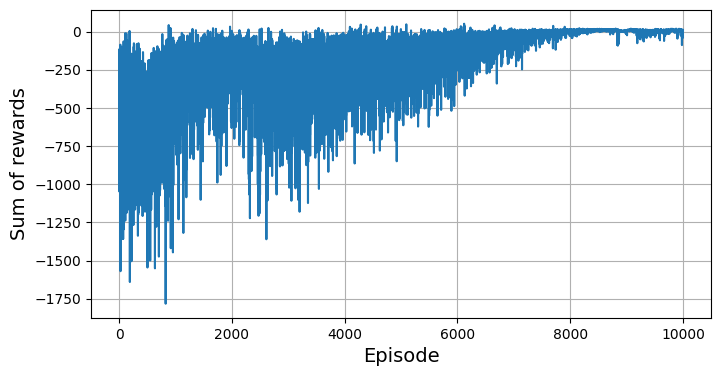

In [ ]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

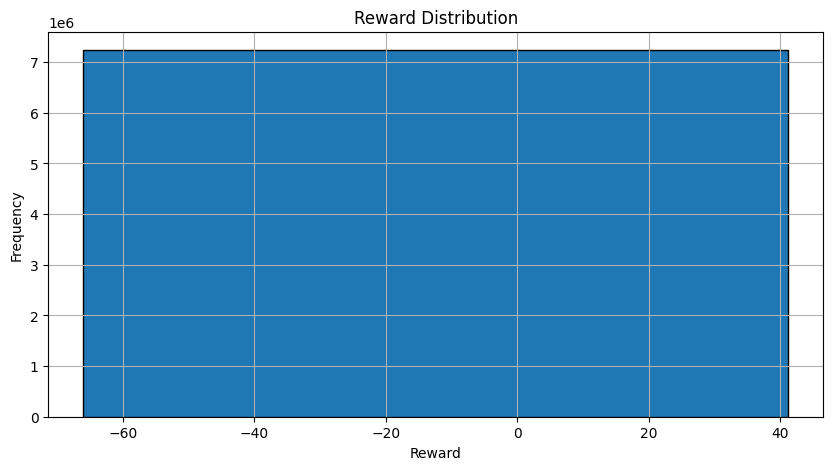

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(reward_log, bins=1, edgecolor='black')
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()